## Introduction

Spam is a brand of canned meat product made from processed ham and ground pork.

![Spam Wall](SpamWallEdit.jpg)

However, for the purpose of this notebook, spam is generally a type of unwanted email/message that is sent out in bulk. Many instances of spam are sent for commercial purposes, resulting in attention theft, but some may be for more malicous purposes and may include shady links or malware attachments.

In these notes, I will use Naïve Bayes to implement a relatively simple spam filter, using a small data set to train and test the model.

The dataset initially used for this model was provided by my university. I have researched some alternative sets that could also be used alongside this spam filter algorithm:

* https://huggingface.co/datasets/TrainingDataPro/email-spam-classification
* https://www.kaggle.com/datasets/cavinlobo/email-classification-dataset

**Note** - This project was first an assigment for a university course, and for education purposes, the use of scikit-Learn libraries or similar was not permitted. Instead, I implemented the Naïve Bayes classifier algorithms completey from scratch. Here's the formula for Baye's Theorem

$P\left(S\middle|\ E\right)=\frac{P\left(E\middle|\ S\right)P\left(S\right)}{P\left(E\middle|\ S\right)P\left(S\right)+P\left(E|\lnot S\right)P\left(\lnot S\right)}$

Where:
$P\left(S\middle|\ E\right)$, the probability that the message is spam given the event occurred.
$P\left(S\right)$, the prior probability that a message is spam.
$P\left(\lnot S\right)$, the prior probability that a message is not spam.

Note:  $P\left(S\right)$ and $P\left(\lnot S\right)$ are prior values, or prior beliefs.  This value could be calculated using the number of spam and number of ham classifications in the data set.  I could also use arbitrary values, for example; I could assume that of all email messages sent, 80% of them are spam and 20% of them are not spam.  The success of the filter depends on the prior values.

$P\left(E\middle|\ S\right)$, the probability that event E occurs in a spam emails.

$P\left(E|\lnot S\right)$, the probability that event E occurs in non-spam emails.

## 1. Preparing the Dataset

The first step is to read the dataset into a variable, like `df`, from the csv file. Outputting the first 20 rows helps to get a general idea of what we're working with at the moment.

In [1]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
print(df.head(20))

      v1                                                 v2
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...
5   spam  FreeMsg Hey there darling it's been 3 week's n...
6    ham  Even my brother is not like to speak with me. ...
7    ham  As per your request 'Melle Melle (Oru Minnamin...
8   spam  WINNER!! As a valued network customer you have...
9   spam  Had your mobile 11 months or more? U R entitle...
10   ham  I'm gonna be home soon and i don't want to tal...
11  spam  SIX chances to win CASH! From 100 to 20,000 po...
12  spam  URGENT! You have won a 1 week FREE membership ...
13   ham  I've been searching for the right words to tha...
14   ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15  spam  XXXMobileMovieClub: To use you

C:\Users\affan\AppData\Local\Temp\ipykernel_15804\1007053535.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


The idea behind the algorithm is to take individual words from messages and essentially give each word a rating based on how common it is in spam messages. Then, for any new message, we can essentially just average the rating of each word to give an overall rating for this message.

**Pros of this method:**
* Easy to implement
* Time-efficient

**Cons of this method.**
* A word's spam rating technically varies between messages based on context. This algorithm will not consider connections between words, and hence it does not account for overall contexts of messages.

For the purpose of this assigment, this algorithm is more suitable to implement compared to more complicated algorithms, albeit less effective. 

Having read in the data, I now need to clean the data and there are a few things to do:
* Remove all punctuation (should only have alpha characters and spaces)
* Ensure all characters are lowercase

The frame should be of a similar format to the sample below:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Category</th>
      <th>Message</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>ham</td>
      <td>go until jurong point crazy available only in ...</td>
    </tr>
    <tr>
      <th>1</th>
      <td>ham</td>
      <td>ok lar joking wif u oni</td>
    </tr>
    <tr>
      <th>2</th>
      <td>spam</td>
      <td>free entry in  a wkly comp to win fa cup final...</td>
    </tr>
    <tr>
      <th>3</th>
      <td>ham</td>
      <td>u dun say so early hor u c already then say</td>
    </tr>
    <tr>
      <th>4</th>
      <td>ham</td>
      <td>nah i dont think he goes to usf he lives aroun...</td>
    </tr>
  </tbody>
</table>

In [2]:
df['v2'] = df['v2'].str.replace('[^a-zA-z]', '')
df['v2'] = df['v2'].str.lower()
print(df.head(20))

      v1                                                 v2
0    ham  go until jurong point, crazy.. available only ...
1    ham                      ok lar... joking wif u oni...
2   spam  free entry in 2 a wkly comp to win fa cup fina...
3    ham  u dun say so early hor... u c already then say...
4    ham  nah i don't think he goes to usf, he lives aro...
5   spam  freemsg hey there darling it's been 3 week's n...
6    ham  even my brother is not like to speak with me. ...
7    ham  as per your request 'melle melle (oru minnamin...
8   spam  winner!! as a valued network customer you have...
9   spam  had your mobile 11 months or more? u r entitle...
10   ham  i'm gonna be home soon and i don't want to tal...
11  spam  six chances to win cash! from 100 to 20,000 po...
12  spam  urgent! you have won a 1 week free membership ...
13   ham  i've been searching for the right words to tha...
14   ham                i have a date on sunday with will!!
15  spam  xxxmobilemovieclub: to use you

In the dataframe, we were given quite a large amount of data, so to use it most effectively, I can split it into three sets for training (70%), validation (20%) and testing (10%). 

In [3]:
shuffled_df = df.sample(frac=1, random_state=1)

train_end = int(0.7 * len(df))
validation_end = int(0.9 * len(df))

train_data, validation_data, test_data = np.split(shuffled_df, [train_end, validation_end])

C:\Users\affan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## 2. Designing the Algorithm

To start with implementing the core algorithm, I will first need to create a new dataframe from the training set containing each word with the number of times it appears in spam messages, and the number of times it appears in ham messages. 

Below is an example of what the dataframe would look like:
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Word</th>
      <th>#Spam</th>
      <th>#Ham</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>go</td>
      <td>27</td>
      <td>196</td>
    </tr>
    <tr>
      <td>1</td>
      <td>until</td>
      <td>4</td>
      <td>17</td>
    </tr>
    <tr>
      <td>2</td>
      <td>jurong</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td>3</td>
      <td>point</td>
      <td>1</td>
      <td>9</td>
    </tr>
    <tr>
      <td>4</td>
      <td>crazy</td>
      <td>4</td>
      <td>8</td>
    </tr>
    <tr>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    <tr>
      <td>7253</td>
      <td>salesman</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td>7254</td>
      <td>pity</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td>7255</td>
      <td>soany</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td>7256</td>
      <td>suggestions</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td>7257</td>
      <td>bitching</td>
      <td>1</td>
      <td>0</td>
    </tr>
  </tbody>
</table>

In [ ]:
spam_words = {}
ham_words = {}

for index, row in train_data.iterrows():
    cleaned_text = re.sub('[^a-zA-Z]', ' ', row['v2']).lower()
    for word in cleaned_text.split():
        if row['v1'] == 'spam':
            if word in spam_words:
                spam_words[word] += 1
            else:
                spam_words[word] = 1
        else:
            if word in ham_words:
                ham_words[word] += 1
            else:
                ham_words[word] = 1

spam_words_df = pd.DataFrame(spam_words.items(), columns=['word', 'frequency'])
ham_words_df = pd.DataFrame(ham_words.items(), columns=['word', 'frequency'])

spam_words_df = spam_words_df.rename(columns={'frequency': 'spam_frequency'})
ham_words_df = ham_words_df.rename(columns={'frequency': 'ham_frequency'})

word_frequencies = pd.merge(spam_words_df, ham_words_df, on='word', how='outer')
word_frequencies = word_frequencies.fillna(0)

word_frequencies = word_frequencies.set_index('word')
print(word_frequencies.tail(20))

         spam_frequency  ham_frequency
word                                  
yummmm              0.0            1.0
yummy               0.0            2.0
yun                 0.0            4.0
yunny               0.0            1.0
yup                 0.0           27.0
yupz                0.0            1.0
z                   0.0            1.0
zac                 0.0            1.0
zaher               0.0            1.0
zealand             0.0            1.0
zebra               1.0            0.0
zed                 5.0            0.0
zeros               0.0            1.0
zf                  1.0            0.0
zhong               0.0            1.0
zindgi              0.0            2.0
zoe                 1.0            1.0
zoom                0.0            1.0
zs                  1.0            0.0
zyada               0.0            1.0


It could be useful to use a  Word Cloud library to visualise the most common words contained in spam messages

I'll use the wordcloud and the matplotlib libraries to plot a simple word cloud, using the spam frequencies.

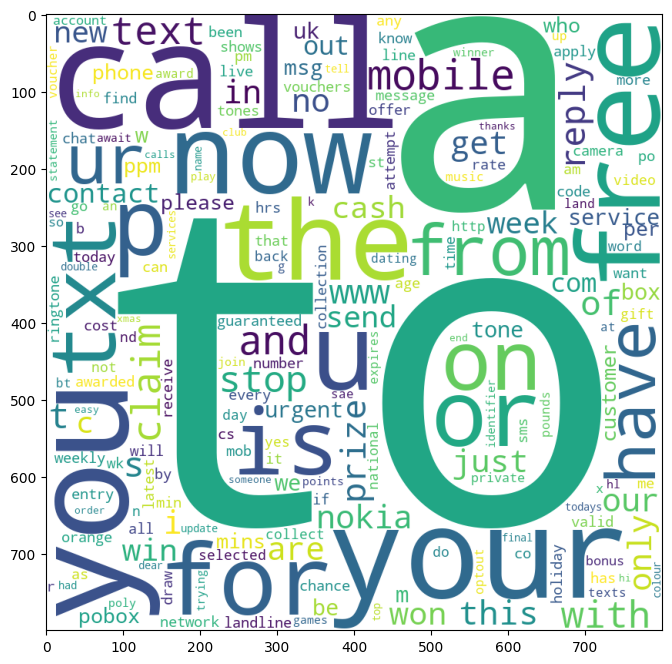

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate_from_frequencies(spam_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)

Next, I need to calculate the probability of each word being found in a spam message and a ham message.

To calculate the probability of it being found in spam, I can just divide the number of times it was found in spam by the total number of spam messages, and similar for the probability of the word being found in ham messages.

If a word is not found in either ham or spam, this will cause problems later since this probability will just be zero. Therefore, I will use a pseudocount k and estimate the probability of seeing the word. This is known as smoothing and results in the following gormula when k = 0.5, for example.

$P\left(E\middle| S\right)$ = (number of spams containing the word + k) / (total number of spam messages + 2 * k).

Likewise for $P\left(E|\lnot S\right)$.

I will create a new dataframe to store these new probabilities, which will be of a similar format to this:
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Word</th>
      <th>P(E|S)</th>
      <th>P(E|¬S)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>go</td>
      <td>0.053322</td>
      <td>0.050055</td>
    </tr>
    <tr>
      <th>1</th>
      <td>until</td>
      <td>0.011364</td>
      <td>0.004275</td>
    </tr>
    <tr>
      <th>2</th>
      <td>jurong</td>
      <td>0.002622</td>
      <td>0.000138</td>
    </tr>
    <tr>
      <th>3</th>
      <td>point</td>
      <td>0.002622</td>
      <td>0.002344</td>
    </tr>
    <tr>
      <th>4</th>
      <td>crazy</td>
      <td>0.011364</td>
      <td>0.002344</td>
    </tr>
  </tbody>
</table>

In [6]:
#smoothing factor = 0.5
word_frequencies['P(E|S)'] = (word_frequencies['spam_frequency'] + 0.5) / (len(spam_words) + 0.5)
word_frequencies['P(E|¬S)'] = (word_frequencies['ham_frequency'] + 0.5) / (len(ham_words) + 0.5)

word_frequencies.drop(['spam_frequency', 'ham_frequency'], axis=1, inplace=True)

print(word_frequencies.head(20))

              P(E|S)   P(E|¬S)
word                          
a           0.158128  0.131901
aa          0.000277  0.000272
aah         0.000277  0.000272
aaniye      0.000277  0.000272
aathi       0.000277  0.000816
ab          0.000831  0.000091
abdomen     0.000277  0.000272
aberdeen    0.000831  0.000091
abi         0.000277  0.000635
ability     0.000277  0.000453
abiola      0.000277  0.001904
abj         0.000277  0.000453
able        0.000277  0.002810
about       0.002492  0.020760
above       0.000277  0.000272
absence     0.000277  0.000272
absolutely  0.000277  0.000272
abstract    0.000277  0.000272
abt         0.000277  0.003717
abta        0.000831  0.000091


Now, we have all the data needed to calculate the 'spamliness' of a single word. Before I get to the testing stage, I will first use the Bayes theorem formula to see if everything works alright.

### $P\left(S\middle|\ E\right)=\frac{P\left(E\middle|\ S\right)P\left(S\right)}{P\left(E\middle|\ S\right)P\left(S\right)+P\left(E|\lnot S\right)P\left(\lnot S\right)}$

I have already calculated $P\left(E\middle| S\right)$ and $P\left(E|\lnot S\right)$, so we can just extract these values from the word_prob DataFrame.

For the prior values, $P\left(S\right)$ and $P\left(\lnot S\right)$, I can experiment with different values to tweak the model. I initially decided on $0.35$ as the prior value for spam and $0.65$ as the prior value for ham for this model.

In [7]:
def CalculateP_S_E(frequencies, word, P_S, P_not_S):
    P_E_S = frequencies.loc[word, 'P(E|S)']
    P_E_not_S = frequencies.loc[word, 'P(E|¬S)']
    P_S_E = ((P_E_S * P_S) / ((P_E_S * P_S) + (P_E_not_S * P_not_S)))
    return P_S_E

P_S = 0.35 #prior
P_not_S = 1 - P_S

word = 'free'

P_S_E = CalculateP_S_E(word_frequencies, word, P_S, P_not_S)
print("Word: " + word)
print(f'P(S|E) = {P_S_E}')

Word: free
P(S|E) = 0.8442257168432051


To check the spamliness of several words contained in a message, I can multiply the probabilities. The model assumes the words appear as independent events hence the naïve Bayes.  In reality of course, words are not independent events, but the model still performs well. So I can use the assumption that the words appear independently, and hence multiply probabilities, so
$P(S\,|\, x_1,\dots,x_n)\approx \frac{P(S)\underset{i=1}{\overset{n}{\prod}}P(x_i | S)}{P(S)\underset{i=1}{\overset{n}{\prod}}P(x_i | S)+P(\neg S)\underset{i=1}{\overset{n}{\prod}}P(x_i | \neg S)}$

For a given message, it would make sense to record the 'spamliness' of each word in the message, and likewise for each word not being spam as well. Then, I can multiply the probabilities and compare the results.

If the result of multiplying the probabilities for spam is greater than the result of multiplying the probabilities for not spam, then it can be assumed the message is spam.

Another slight issue with this model that I discover at this point is that if a word is not in the list of words I have already, it will just give a probability of zero. Of course, multiplying by the probability og zero will just mess up the whole calculation. So if the model comes across a word it is not familiar with, it should just skip it.
Calculate the probability for each word in a message being spam, you might want to store the calculations in a list named prob_spam.  Likewise create a list for each word not being spam.

In [8]:
message = "free food here"
words = re.sub('[^a-zA-Z]', ' ', message).lower().split()

prob_spam = []
prob_not_spam = []

for word in words:
    if word in word_frequencies.index:
        P_S_E = CalculateP_S_E(word_frequencies, word, P_S, P_not_S)
        prob_spam.append(P_S_E)
        prob_not_spam.append(1 - P_S_E)

prob_spam = np.prod(prob_spam)
prob_not_spam = np.prod(prob_not_spam)

print("Message: " + message)
print(f'Probability of spam: {prob_spam}')
print(f'Probability of not spam: {prob_not_spam}')

Message: free food here
Probability of spam: 0.0027518432243739963
Probability of not spam: 0.1374312530806387


The aim is to compare two probabilities $P(S|x_1,\dots,x_n)$ with $P(\neg S|x_1,\dots,x_n)$. Both probabilities share a common denominator which does not affect comparison. Hence I will calculate numerators only, which are proportional to $P(S|x_1,\dots,x_n)$ and $P(\neg S|x_1,\dots,x_n).$

Multiplying a set of small probabilities could result in a floating-point error.  This is where the product becomes too small to be represented correctly.  To avoid this I can take the logarithm of the probabilities and add them.  

To avoid multiplication of small numbers, I'll use the following property of $\log(x):$</p>
$$
\log(a\cdot b)=\log(a)+\log(b)
$$
i.e. the log of the product is equal to the sum of logs (so instead of multiplying small numbers I will add them):
$$
P(S|x_1,x_2,\dots,x_n)\propto P(S)\cdot P(x_1|S)\cdot \dots \cdot P(x_n|S)
$$
becomes
$$
\log(P(S|x_1,x_2,\dots,x_n))\propto \log\left(P(S)\cdot P(x_1|S)\cdot \dots  P(x_n|S)\right) = \log(P(S))+\log(P(x_1|S))+\dots+\log(P(x_n|S))
$$
So, to check spam or ham we just compare:
$$
\log(P(S))+\log(P(x_1|S))+\dots+\log(P(x_n|S))
$$
and
$$
\log(P(\neg S))+\log(P(x_1|\neg S))+\dots+\log(P(x_n|\neg S))
$$


Effectively, we are just changing the equation so that logs are used.

To make things easier when it comes to validation and testing, I will also create function called `classify_message` which should handle all the classification.

In [17]:
def classify_message(message, new_word_frequencies, P_S, P_not_S, CalculateP_S_E):
    words = re.sub('[^a-zA-Z]', ' ', message).lower().split()

    prob_spam = []
    prob_not_spam = []

    for word in words:
        if word in new_word_frequencies.index:
            P_S_E = CalculateP_S_E(new_word_frequencies, word, P_S, P_not_S)
            prob_spam.append(np.log(P_S_E))
            prob_not_spam.append(np.log(1 - P_S_E))

    prob_spam = np.sum(prob_spam)
    prob_not_spam = np.sum(prob_not_spam)

    # print("Message: " + message)
    # print(f'Probability of spam: {prob_spam}')
    # print(f'Probability of not spam: {prob_not_spam}')

    if prob_spam > prob_not_spam:
        return "spam"
    else:
        return "ham"
    
message = "WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
print(classify_message(message, word_frequencies, P_S, P_not_S, CalculateP_S_E))

spam


### Testing the Model

I have already tested the model using simple messages, but I can now test the model using the messages from the `test_set`. Using counters, I've counted up the ham and spam occurrences and other useful results based on how well the model performs.

At the end, I have calculated an accuracy for the model.

In [10]:
test_data['prediction'] = test_data['v2'].apply(lambda x: classify_message(x, word_frequencies, P_S, P_not_S, CalculateP_S_E))
test_data['correct'] = (test_data['v1'] == test_data['prediction'])

#model stats
match_spam = len(test_data[(test_data['v1'] == 'spam') & (test_data['prediction'] == 'spam')])
match_ham = len(test_data[(test_data['v1'] == 'ham') & (test_data['prediction'] == 'ham')])
thought_spam_but_ham = len(test_data[(test_data['v1'] == 'spam') & (test_data['prediction'] == 'ham')])
thought_ham_but_spam = len(test_data[(test_data['v1'] == 'ham') & (test_data['prediction'] == 'spam')])
print(f'Match spam: {match_spam}')
print(f'Match ham: {match_ham}')
print(f'Thought spam but ham: {thought_spam_but_ham}')
print(f'Thought ham but spam: {thought_ham_but_spam}')

#accuracy of the model
accuracy = len(test_data[test_data['correct'] == True]) / len(test_data) 
print(f'Accuracy: {accuracy}')

Match spam: 59
Match ham: 487
Thought spam but ham: 12
Thought ham but spam: 0
Accuracy: 0.978494623655914


### Improvements

The model performed really well on the `test_data`, producing an accuracy of ~97.8%.

I can now use the `validation_set` to take a closer look at how the model performs and if it's accuracy could be improved.

In [11]:
#a function which takes in the training data and returns the word frequencies dataframe
def get_word_frequencies(trainData):
    spam_words = {}
    ham_words = {}

    for index, row in trainData.iterrows():
        cleaned_text = re.sub('[^a-zA-Z]', ' ', row['v2']).lower()
        for word in cleaned_text.split():
            if row['v1'] == 'spam':
                if word in spam_words:
                    spam_words[word] += 1
                else:
                    spam_words[word] = 1
            else:
                if word in ham_words:
                    ham_words[word] += 1
                else:
                    ham_words[word] = 1

    spam_words_df = pd.DataFrame(spam_words.items(), columns=['word', 'frequency'])
    ham_words_df = pd.DataFrame(ham_words.items(), columns=['word', 'frequency'])

    spam_words_df = spam_words_df.rename(columns={'frequency': 'spam_frequency'})
    ham_words_df = ham_words_df.rename(columns={'frequency': 'ham_frequency'})

    word_frequencies = pd.merge(spam_words_df, ham_words_df, on='word', how='outer')
    word_frequencies = word_frequencies.fillna(0)

    word_frequencies = word_frequencies.set_index('word')

    word_frequencies['P(E|S)'] = (word_frequencies['spam_frequency'] + 0.5) / (len(spam_words) + 0.5)
    word_frequencies['P(E|¬S)'] = (word_frequencies['ham_frequency'] + 0.5) / (len(ham_words) + 0.5)
    return word_frequencies

#I can use the function above to generate the word frequencies for my probability calculations using new training data

In [12]:
#this function will take in the data that the model is tested on and prints the model
def GetSetReview(data, frequencies):
    data = data.copy()
    data.loc[:, 'prediction'] = data['v2'].apply(lambda x: classify_message(x, frequencies, P_S, P_not_S, CalculateP_S_E))
    data.loc[:, 'correct'] = (data['v1'] == data['prediction'])
    match_spam = len(data[(data['v1'] == 'spam') & (data['prediction'] == 'spam')])
    match_ham = len(data[(data['v1'] == 'ham') & (data['prediction'] == 'ham')])
    thought_spam_but_ham = len(data[(data['v1'] == 'spam') & (data['prediction'] == 'ham')])
    thought_ham_but_spam = len(data[(data['v1'] == 'ham') & (data['prediction'] == 'spam')])
    print(f'Match spam: {match_spam}')
    print(f'Match ham: {match_ham}')
    print(f'Thought spam but ham: {thought_spam_but_ham}')
    print(f'Thought ham but spam: {thought_ham_but_spam}')

    #calculate the accuracy of the model
    accuracy = len(data[data['correct'] == True]) / len(data)
    print(f'Accuracy: {accuracy}')

#this function takes the validation data and runs the spam filter on various subsets of the validation set and the entire validation set to produce model statistics
def GetValidationSetReview(frequencies):
    validation_data['word_count'] = validation_data['v2'].apply(lambda x: len(x.split()))

    #only messages with 25 or more words
    thirty_plus_words = validation_data[validation_data['word_count'] >= 25]
    print("Validating - Messages with 25 or more words")
    GetSetReview(thirty_plus_words, frequencies)

    print("-----")

    #only messages with 5 or less words
    five_less_words = validation_data[validation_data['word_count'] <= 5]
    print("Validating - Messages with 5 or less words")
    GetSetReview(five_less_words, frequencies)

    print("-----")

    #only messages that contain the word free
    contains_free = validation_data[validation_data['v2'].str.contains('free', case=False, na=False)]
    print("Validating - Messages containing the word 'free'")
    GetSetReview(contains_free, frequencies)

#After building the model with different training data, I can use the function above to test the model on the validation data

In [13]:
#Making tweaks to the trainig data
print("Using default data")
GetSetReview(validation_data, word_frequencies)
print("-------------------------------------------------")
print("Removing words that appear less than 10 times")
new_train_data = train_data.copy()
new_word_frequencies = get_word_frequencies(new_train_data)
new_word_frequencies = new_word_frequencies[(new_word_frequencies['spam_frequency'] + new_word_frequencies['ham_frequency']) > 10]
GetSetReview(validation_data, word_frequencies)
print("-------------------------------------------------")
print("Removing words that appear more than 500 times")
new_train_data = train_data.copy()
new_word_frequencies = get_word_frequencies(new_train_data)
new_word_frequencies['total_frequency'] = new_word_frequencies['spam_frequency'] + new_word_frequencies['ham_frequency']
frequency_threshold = 500
new_word_frequencies = new_word_frequencies[new_word_frequencies['total_frequency'] <= frequency_threshold]
GetSetReview(validation_data, new_word_frequencies)
print("-------------------------------------------------")
#tweaking prior
print("Tweaking the prior")
P_S = 0.4
P_not_S = 1 - P_S
GetSetReview(validation_data, new_word_frequencies)

print("")
print("-----------------------------------------------------")
print("Validating the model for validation subsets")
GetValidationSetReview(new_word_frequencies)


Using default data
Match spam: 110
Match ham: 975
Thought spam but ham: 27
Thought ham but spam: 2
Accuracy: 0.973967684021544
-------------------------------------------------
Removing words that appear less than 10 times
Match spam: 110
Match ham: 975
Thought spam but ham: 27
Thought ham but spam: 2
Accuracy: 0.973967684021544
-------------------------------------------------
Removing words that appear more than 500 times
Match spam: 118
Match ham: 975
Thought spam but ham: 19
Thought ham but spam: 2
Accuracy: 0.981149012567325
-------------------------------------------------
Tweaking the prior
Match spam: 124
Match ham: 970
Thought spam but ham: 13
Thought ham but spam: 7
Accuracy: 0.9820466786355476

-----------------------------------------------------
Validating the model for validation subsets
Validating - Messages with 25 or more words
Match spam: 62
Match ham: 137
Thought spam but ham: 7
Thought ham but spam: 0
Accuracy: 0.9660194174757282
-----
Validating - Messages with 5 o

#### Conclusion

* Removing words with low frequency had no noticeable effect on the spam fitler's accuracy
* Removing words with high frequency in both spam and ham messages increased the accuracy of the filter from 97.4% to about 98.1%
* Changing the prior from 0.35 to 0.4 increase the accuracy a bit more to 98.2%
* Based on the subsets of the validation set, the filter works to a similar level of accuracy in varying word counts, but yields a lower accuracy for messages containing the word 'free'

#### Potential further changes
* Check for punctuation in the messages as well to better assess messages containing links and file names
* Check for character case, e.g. "FREE" could be more likely to be used in spam messages than "free"
* Use other factors for context when classifying messages, such as the time the email was sent, the subject line and the sender email

###### By Mohammad Affan Khan. Last Updated: 20/07/2024